# Run lunar lander - DQN

### Author: lyds 
***

Here we train our `ActionBot` using a deep Q learning approach

In [1]:
import sys
sys.path.append("..")

In [2]:
import gym
from uuid import uuid4
import os
import datetime
import numpy as np
from collections import deque
from pathlib import Path

from src.episode_memory import LanderMemory
from src.replay_memory import ReplayMemory
from src.action_bot import DQNActionBot
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark

%watermark -u -n -t
%watermark -iv -v

last updated: Mon Jan 27 2020 10:02:58
gym        0.12.0
matplotlib 3.0.3
numpy      1.16.2
CPython 3.6.8
IPython 7.2.0


#### Set up training parameters
***

In [5]:
env_name = "LunarLander-v2"
total_episodes = 2500
max_time_steps = 512
env_seed = None
unique_run = None

load = False
save = True
rendering = False
replay = False

In [6]:
if unique_run is None:
    unique_run = uuid4()

#### Instantiate objects
***

In [7]:
def get_memory(env_name):
    if env_name == "LunarLander-v2":
        return LanderMemory()
    else:
        raise ValueError

In [8]:
if total_episodes < 1:
    raise ValueError("Cannot have number of episodes less than 1")

env = gym.make(env_name)
replay_memory = ReplayMemory()

action_bot = DQNActionBot(env)
if load:
    action_bot.load_dqn_weights(unique_run)

Print out set training parameters

In [9]:
print(f"{action_bot.params}, \n{replay_memory.params}")

{'learn_rate': 0.0005, 'gamma': 0.98, 'tau': 0.001, 'epsilon_min': 0.025}, 
{'buffer_size': 10000, 'batch_size': 64, 'update_every': 4}


Save the best memory and reward history

In [10]:
best_memory = get_memory(env_name)
best_memory.total_reward = -np.inf
reward_vals = []
reward_window = deque(maxlen=100)

#### Train
***

We train using a Q-learning approach.

In [11]:
%%time
SUCCESS_LIMIT = 200
converged = False

print("Starting training...")
for episode_number in range(total_episodes):
    
    # record memories
    episode_memory = get_memory(env_name)
    if env_seed is not None:
        episode_memory.seed = env_seed
    env.seed(episode_memory.seed)
    
    # set up episode run
    obs = env.reset()
    done = False
    t = 0

    while not done and t <= max_time_steps:
        if rendering:
            env.render()
        
        # get action
        action_bot.obs = obs
        action_bot.episode_n = episode_number
        action = action_bot.get_dq_action()
        new_obs, reward, done, _ = env.step(action)
        action_bot.next_obs = new_obs

        episode_memory.update(action, reward)
        experiences, learn = replay_memory.update(
            obs, action, reward, new_obs, done, episode_number
        )
        if learn:
            action_bot.learn(experiences)
        obs = new_obs
        t += 1

    env.close()

    if episode_number % 100 == 0 and episode_number > 0:
        print(
            f"Rolling average reward for episode:{episode_number} = {np.mean(reward_window)}"
        )

    if episode_number > 0 and episode_number % 500 == 0 and save:
        action_bot.save_dqn_weights(unique_run)

    reward_vals.append(episode_memory.total_reward)
    reward_window.append(episode_memory.total_reward)

    if best_memory.total_reward < episode_memory.total_reward:
        best_memory = episode_memory

    if np.mean(reward_window) > SUCCESS_LIMIT:
        converged = True
        print(f"----- Converged after {episode_number} episodes! -----")
        break

print(f"Highest total reward = {best_memory.total_reward}")
print(f"Average total reward = {sum(reward_vals) / total_episodes}")

if save:
    action_bot.save_dqn_weights(unique_run)

    logging_file = Path("../training_history/logging.txt")
    if not logging_file.exists():
        logging_file.open(mode="a").write(
            "date, env, run_id, converged, episodes_to_complete, mean_reward\n"
        )

    logging_file.open(mode="a").write(
        f"{datetime.datetime.now().isoformat()}, "
        f"{env_name}, "
        f"{unique_run}, "
        f"{converged}, "
        f"{episode_number + 1}, "
        f"{np.mean(reward_window)}\n"
    )

Starting training...
Rolling average reward for episode:100 = -177.8363566015333
Rolling average reward for episode:200 = -74.33168956007663
Rolling average reward for episode:300 = -37.71779860742737
Rolling average reward for episode:400 = -47.54442410057567
Rolling average reward for episode:500 = -5.121636962159381
Saved DQN weights!
Rolling average reward for episode:600 = 23.710408974079417
Rolling average reward for episode:700 = 37.30207952605424
Rolling average reward for episode:800 = 45.28407897529256
Rolling average reward for episode:900 = 97.93391145325182
Rolling average reward for episode:1000 = 66.52719218561299
Saved DQN weights!
Rolling average reward for episode:1100 = 90.12726373621382
Rolling average reward for episode:1200 = 141.87894784993424
----- Converged after 1260 episodes! -----
Highest total reward = 305.1346471388705
Average total reward = 11.667955885090961
Saved DQN weights!
Wall time: 59min 37s


Plot the training history with a rolling mean

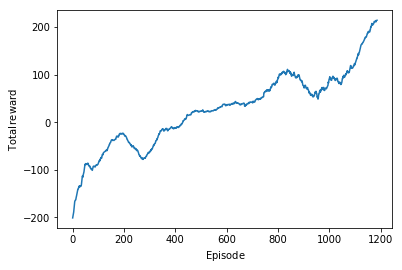

In [12]:
N = 75
plt.plot(np.convolve(reward_vals, np.ones((N,))/N, mode='valid'))
plt.xlabel(r"$\mathrm{Episode}$")
plt.ylabel(r"$\mathrm{Total \/ reward}$")
plt.show()

Show the best episode that we experienced

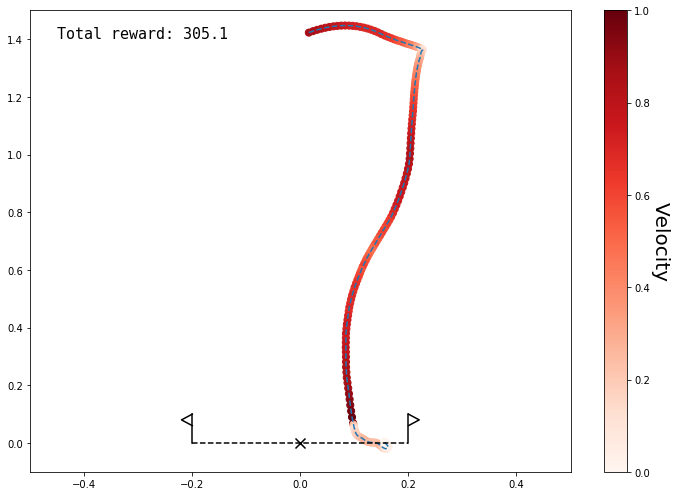

In [13]:
best_memory.replay(False, True)

#### Demo the model
***
Load in a model with fitted weights and run an episode


Loaded DQN weights!


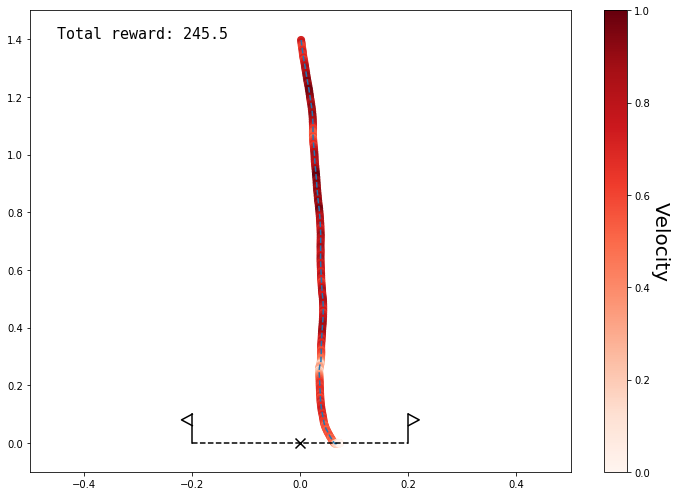

Total reward for memory: 245.52


In [14]:
env = gym.make(env_name)
action_bot = DQNActionBot(env)
# unique_run = "1f46aa2c-6e2d-4b71-af7c-28243ecddb10"
action_bot.load_dqn_weights(unique_run)
action_bot.demo = True

# set up episode run
episode_memory = get_memory(env_name)
if env_seed is not None:
    episode_memory.seed = env_seed
env.seed(episode_memory.seed)
obs = env.reset()
done = False
t = 0

while not done and t <= max_time_steps:
    # get action
    action_bot.obs = obs
    action_bot.episode_n = 1
    action = action_bot.get_dq_action()
    # update action bot
    new_obs, reward, done, _ = env.step(action)   
    episode_memory.update(action, reward)
    obs = new_obs
    t += 1
    
episode_memory.replay(True, True)
print(f"Total reward for memory: {episode_memory.total_reward:.2f}")